In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import os
import datetime
from math import sqrt

import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Dropout, Flatten
from keras.layers import  regularizers

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#import data
data = pd.read_csv("../FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [3]:
data.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,16,533.33333,I,237784,52.353,52.474,52.951
1,13,433.33333,B,191888,48.114,49.612,50.446
2,14,466.66667,B,198992,48.003,49.608,50.231
3,15,500.00000,B,136112,48.290,50.312,51.118
4,20,666.66667,P,296416,49.951,50.910,51.201


In [4]:
data.dropna(0,inplace= True)

In [5]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)
data.drop(('x'), axis=1, inplace=True)
data.drop(('y'), axis=1, inplace=True)
data.drop(('z'), axis=1, inplace=True)
data.drop(('arrival_time'), axis=1, inplace=True)

In [6]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [7]:
data.head(5)

,video_frame,frame_size
0,1,237784
1,0,191888
2,0,198992
3,0,136112
4,2,296416


In [8]:
output = []
#for l in lag:
for i in range(0, len(data.frame_size)):
    output.append(data['frame_size'].autocorr(i))

In [9]:
len(output), data.shape[0]

(11846, 11846)

In [10]:
data['auto_corr'] = output
data.head(10)

,video_frame,frame_size,auto_corr
0,1,237784,1.000000
1,0,191888,0.037585
2,0,198992,0.105441
3,0,136112,0.028369
4,2,296416,0.780696
5,0,151368,0.015772
6,0,175072,0.083574
7,0,155936,0.003360
8,2,289312,0.760796
9,0,144080,-0.004946


In [11]:
#zero_data = data[ data['video_frame'] == 0 ]


#data['auto_corr'] = data['frame_size'].autocorr()
data['auto_corr_next']  = data['auto_corr'].shift(-1)
data.head(10)

,video_frame,frame_size,auto_corr,auto_corr_next
0,1,237784,1.000000,0.037585
1,0,191888,0.037585,0.105441
2,0,198992,0.105441,0.028369
3,0,136112,0.028369,0.780696
4,2,296416,0.780696,0.015772
5,0,151368,0.015772,0.083574
6,0,175072,0.083574,0.003360
7,0,155936,0.003360,0.760796
8,2,289312,0.760796,-0.004946
9,0,144080,-0.004946,0.065992


In [12]:
data['comparison_auto_corr'] = np.where(data["auto_corr"] > data["auto_corr_next"], 1, 0)
data.head()

,video_frame,frame_size,auto_corr,auto_corr_next,comparison_auto_corr
0,1,237784,1.000000,0.037585,1
1,0,191888,0.037585,0.105441,0
2,0,198992,0.105441,0.028369,1
3,0,136112,0.028369,0.780696,0
4,2,296416,0.780696,0.015772,1


In [13]:
data = data.dropna()

In [14]:
data['comparison_auto_corr'] = data['frame_size'] * data['comparison_auto_corr']
data.head(10)

,video_frame,frame_size,auto_corr,auto_corr_next,comparison_auto_corr
0,1,237784,1.000000,0.037585,237784
1,0,191888,0.037585,0.105441,0
2,0,198992,0.105441,0.028369,198992
3,0,136112,0.028369,0.780696,0
4,2,296416,0.780696,0.015772,296416
5,0,151368,0.015772,0.083574,0
6,0,175072,0.083574,0.003360,175072
7,0,155936,0.003360,0.760796,0
8,2,289312,0.760796,-0.004946,289312
9,0,144080,-0.004946,0.065992,0


In [15]:
values = data['comparison_auto_corr'].to_dict()

In [16]:

data['comparison_auto_corr'] = 0

for idx, row in data.iterrows():
    data.at[idx, 'comparison_auto_corr'] = values.get(idx, row['frame_size'])

In [17]:
data.head(20)

,video_frame,frame_size,auto_corr,auto_corr_next,comparison_auto_corr
0,1,237784,1.000000,0.037585,237784
1,0,191888,0.037585,0.105441,0
2,0,198992,0.105441,0.028369,198992
3,0,136112,0.028369,0.780696,0
4,2,296416,0.780696,0.015772,296416
5,0,151368,0.015772,0.083574,0
6,0,175072,0.083574,0.003360,175072
7,0,155936,0.003360,0.760796,0
8,2,289312,0.760796,-0.004946,289312
9,0,144080,-0.004946,0.065992,0


In [18]:
data = data.comparison_auto_corr.values #numpy.ndarray

In [19]:
data = pd.DataFrame(data)
print(data.shape)

(11844, 1)


In [20]:
data = data.replace(0, np.nan)
data.dropna(inplace=True)

In [21]:
data.head(10)

,0
0,237784.0
2,198992.0
4,296416.0
6,175072.0
8,289312.0
10,149752.0
12,288384.0
14,158720.0
16,259272.0
18,154600.0


In [22]:
dataset = data.copy()

In [23]:
# *****************split into train and test sets********************

test_split = int(len(dataset) * 0.8)

train = dataset[:test_split]
test = dataset[test_split:]

In [24]:
#********Data normalization**************************

scaler = MinMaxScaler(feature_range=(-1, 1))

train = scaler.fit_transform(train)
test = scaler.transform(test)

In [25]:
# ******************frame a lagged sequence problem*************

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 40
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4696, 40) (4696,)
(1144, 40) (1144,)


In [26]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train',X_train.shape)
print('X_test', X_test.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

X_train (4696, 40, 1)
X_test (1144, 40, 1)


In [27]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

# LSTM

In [28]:
#********************Build Model****************************

def lstm_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(32, input_shape=(look_back,1),kernel_regularizer=regularizers.l2(0.001)
                ))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(128, kernel_initializer='glorot_uniform',activation='relu'))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mse')
      
    return model

In [29]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]

model_lstm =lstm_model()


history_lstm = model_lstm.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs =500, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Train on 3756 samples, validate on 940 samples
Epoch 1/500
3756/3756 [==============================] - 2s 443us/sample - loss: 0.0987 - val_loss: 0.0606
Epoch 2/500
3756/3756 [==============================] - 1s 310us/sample - loss: 0.0607 - val_loss: 0.0588
Epoch 3/500
3756/3756 [==============================] - 1s 308us/sample - loss: 0.0584 - val_loss: 0.0567
Epoch 4/500
3756/3756 [==============================] - 1s 316us/sample - loss: 0.0546 - val_loss: 0.0514
Epoch 5/500
3756/3756 [==================

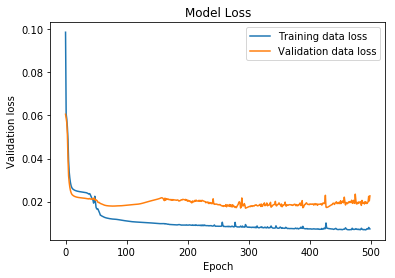

In [30]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [31]:
# convert 1 D to 2D array
y_train = y_train.reshape((y_train.shape[0], 1))
#print(test_y.shape)

# convert 1 D to 2D array
y_test = y_test.reshape((y_test.shape[0], 1))
#print(test_y.shape)

In [32]:
models = pd.DataFrame(index=['rmse', 'rpe'], 
                      columns=[ 'Bagging', 'RF', 'Boosting', 'LSTM','CNN', 'VAE_RF', 'VAE_KNN'])

In [33]:
# Prediction Time !!!!

# Relative Percentage Error
def mean_relative_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

yhat_lstm = model_lstm.predict(X_test)
rpe_lstm = mean_relative_percentage_error(yhat_lstm, y_test)
mse_lstm = mean_squared_error(y_test, yhat_lstm)
rmse_lstm = sqrt(mse_lstm)

#rpe_rnn = mean_relative_percentage_error(y_test, yhat)
models.loc['rpe','LSTM'] = mean_relative_percentage_error(yhat_lstm, y_test)
models.loc['rmse','LSTM'] = sqrt(mse_lstm)
#print ('RPE', rpe_rnn)

print('RPE',rpe_lstm, 'MSE', mse_lstm,'RMSE', rmse_lstm)

RPE 54.581517835472035 MSE 0.014432757318798896 RMSE 0.12013641129482308


# CNN

In [34]:
#********************Build Model****************************

def cnn_model():
    
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, input_shape=(look_back,1)
                    ))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
      
    return model

In [35]:
model_cnn =cnn_model()

history_cnn = model_cnn.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs = 500, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 608)               0         
_________________________________________________________________
dropout (Dropout)            (None, 608)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 609       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________
Train on 3756 samples, validate on 940 samples
Epoch 1/500
3756/3756 [==============================] - 0s 107us/sample - 

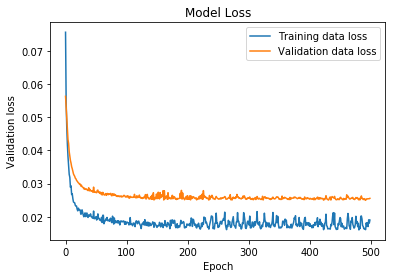

In [36]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [37]:
# Prediction Time !!!!
yhat_cnn = model_cnn.predict(X_test)
rpe_cnn = mean_relative_percentage_error(yhat_cnn, y_test)
mse_cnn = mean_squared_error(y_test, yhat_cnn)
rmse_cnn = sqrt(mse_cnn)

#rpe_cnn = mean_relative_percentage_error(y_test, yhat)

models.loc['rpe','CNN'] = mean_relative_percentage_error(yhat_cnn, y_test)
models.loc['rmse','CNN'] = sqrt(mse_cnn)
#print ('RPE', rpe_cnn)

print('RPE', rpe_cnn, 'MSE', mse_cnn,'RMSE', rmse_cnn)

RPE 29.16661977201656 MSE 0.017253407221427545 RMSE 0.13135222579548297


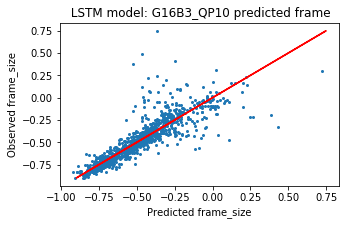

In [38]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(model_lstm.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title(' LSTM model: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

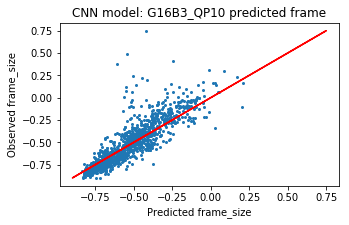

In [39]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(model_cnn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('CNN model: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

In [40]:
# *********************make predictions*************************************************************

trainPredict = model_lstm.predict(X_train)
testPredict = model_lstm.predict(X_test)

# *****************Relative Percentage Error before inverse*****************************************

def mean_relative_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

RPE = round (mean_relative_percentage_error (y_test, testPredict), 2)
print ('Relative Percentage Error before inverse:', RPE)


# *************************invert predictions**************************

trainPredict_inv = scaler.inverse_transform(trainPredict)
train_y_inv = scaler.inverse_transform(y_train)

testPredict_inv = scaler.inverse_transform(testPredict)
test_y_inv = scaler.inverse_transform(y_test)

Relative Percentage Error before inverse: 42.0


In [41]:
# predict the y values
y_pred=model_lstm.predict(X_test)
# a data frame with actual and predicted values of y
evaluate = pd.DataFrame({'Actual': test_y_inv.flatten(), 'Predicted': testPredict_inv.flatten()})
evaluate.head(10)

,Actual,Predicted
0,171472.0,191737.500000
1,263160.0,265936.531250
2,186256.0,180677.890625
3,254408.0,271056.718750
4,156208.0,182102.765625
5,268456.0,247489.203125
6,170568.0,173284.812500
7,265016.0,245194.875000
8,162784.0,171036.828125
9,283432.0,252627.453125


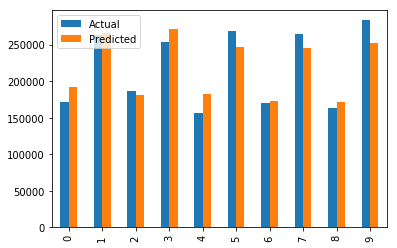

In [42]:
evaluate.head(10).plot(kind = 'bar')

In [43]:
# predict the y values
lstm_predict=model_lstm.predict(X_test)
lstm_predict_inv = scaler.inverse_transform(lstm_predict)
# a data frame with actual and predicted values of y
evaluate1 = pd.DataFrame({'Actual': test_y_inv.flatten(), 'Predicted': lstm_predict_inv.flatten()})
evaluate1.head(10)

,Actual,Predicted
0,171472.0,191737.500000
1,263160.0,265936.531250
2,186256.0,180677.890625
3,254408.0,271056.718750
4,156208.0,182102.765625
5,268456.0,247489.203125
6,170568.0,173284.812500
7,265016.0,245194.875000
8,162784.0,171036.828125
9,283432.0,252627.453125


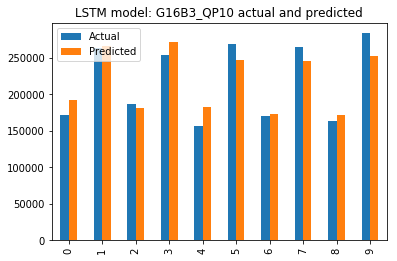

In [44]:
evaluate1.head(10).plot(kind = 'bar')
plt.title('LSTM model: G16B3_QP10 actual and predicted')
plt.show()

In [45]:
# predict the y values
cnn_predict=model_cnn.predict(X_test)
cnn_predict_inv = scaler.inverse_transform(cnn_predict)
# a data frame with actual and predicted values of y
evaluate2 = pd.DataFrame({'Actual': test_y_inv.flatten(), 'Predicted': cnn_predict_inv.flatten()})
evaluate2.head(10)

,Actual,Predicted
0,171472.0,217931.265625
1,263160.0,222650.765625
2,186256.0,212068.687500
3,254408.0,226421.484375
4,156208.0,214595.968750
5,268456.0,218151.296875
6,170568.0,209201.765625
7,265016.0,224623.203125
8,162784.0,210339.968750
9,283432.0,211740.234375


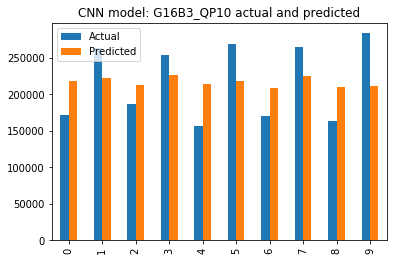

In [46]:
evaluate2.head(10).plot(kind = 'bar')
plt.title('CNN model: G16B3_QP10 actual and predicted')
plt.show()

In [47]:
#import data
data2 = pd.read_csv("../FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [48]:
# check if any null value is present
data2.isnull().values.any()

True

In [49]:
data2.dropna(0,inplace= True)

In [50]:
#drop decoded frame column
data2.drop(('decoded_frame'), axis=1, inplace=True)

In [51]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data2['video_frame'])
print(list(le.classes_))
data2['video_frame'] = le.transform(data2['video_frame'])

['B', 'I', 'P']


In [52]:
output2 = []
#for l in lag:
for i in range(0, len(data2.frame_size)):
    output2.append(data2['frame_size'].autocorr(i))

In [53]:
len(output2), data2.shape[0]

(11846, 11846)

In [54]:
data2['auto_corr'] = output2
data2.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000
1,433.33333,0,191888,48.114,49.612,50.446,0.037585
2,466.66667,0,198992,48.003,49.608,50.231,0.105441
3,500.00000,0,136112,48.290,50.312,51.118,0.028369
4,666.66667,2,296416,49.951,50.910,51.201,0.780696
5,566.66667,0,151368,48.047,50.108,50.692,0.015772
6,600.00000,0,175072,47.957,50.013,50.635,0.083574
7,633.33333,0,155936,47.958,49.909,50.448,0.003360
8,800.00000,2,289312,49.980,50.992,51.375,0.760796
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946


In [55]:
#zero_data = data[ data['video_frame'] == 0 ]


#data['auto_corr'] = data['frame_size'].autocorr()
data2['auto_corr_next']  = data2['auto_corr'].shift(-1)
data2.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992


In [56]:
data2['comparison_auto_corr'] = np.where(data2["auto_corr"] > data2["auto_corr_next"], 1, 0)
data2.head()

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,1
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,1
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,1


In [57]:
data2 = data2.dropna()

In [58]:
data2['comparison_auto_corr'] = data2['frame_size'] * data2['comparison_auto_corr']
data2.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,237784
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,198992
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,296416
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574,0
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360,175072
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796,0
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946,289312
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992,0


In [59]:
values2 = data2['comparison_auto_corr'].to_dict()

In [60]:

data2['comparison_auto_corr'] = 0

for idx, row in data2.iterrows():
    data2.at[idx, 'comparison_auto_corr'] = values2.get(idx, row['frame_size'])

In [61]:
data2.head(20)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,237784
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,198992
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,296416
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574,0
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360,175072
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796,0
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946,289312
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992,0


In [62]:
dataset2 = data2.copy()

In [63]:
dataset2 = dataset2.comparison_auto_corr.values #numpy.ndarray

In [64]:
dataset2 = pd.DataFrame(dataset2)
print(dataset2.shape)

(11844, 1)


In [65]:
dataset2 = dataset2.replace(0, np.nan)
dataset2.dropna(inplace=True)

In [66]:
dataset2.head(10)

,0
0,237784.0
2,198992.0
4,296416.0
6,175072.0
8,289312.0
10,149752.0
12,288384.0
14,158720.0
16,259272.0
18,154600.0


In [71]:
#************** Split data into training and testing***************


#data2 =per_.copy()
test_split = int(len(dataset2) * 0.8)

X_train = dataset2[:test_split]
X_test = dataset2[test_split:]

y_train = dataset2[:test_split]
y_test = dataset2[test_split:]

In [72]:
print(X_train.shape, y_train.shape)

(4737, 1) (4737, 1)


In [73]:
print(X_test.shape, y_test.shape)

(1185, 1) (1185, 1)


In [74]:
# fit scaler on training data
scaler = MinMaxScaler().fit(X_train)

# transform training data
X_train = scaler.transform(X_train)

# transform testing dataabs
X_test = scaler.transform(X_test)

# KNN

# Random Forest

In [75]:
# 1. Import the estimator object (model)
from sklearn.ensemble import RandomForestRegressor

# 2. Create an instance of the estimator
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)

# 3. Use the trainning data to train the estimator
RF.fit(X_train, y_train)

RF_pred = RF.predict(X_test)
# 4. Evaluate the model
#models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), 
                                                  #  y_true=y_train)

models.loc['rmse','RF'] = np.sqrt(mean_squared_error(y_pred=RF.predict(X_test), y_true=y_test))
models.loc['rpe','RF'] = mean_relative_percentage_error(y_pred=RF.predict(X_test), y_true=y_test)

# Prediction Time !!!!
mse = mean_squared_error(y_test, RF_pred)
print(mse)
rmse = sqrt(mse)
print(rmse)

rpe = mean_relative_percentage_error(y_test, RF_pred)
print ('RPE', rpe)

128279.55800573775
358.1613574992949
RPE 33.79145273203002


# Bagging

In [76]:
# 1. Import the estimator object (model)
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor


# 2. Create an instance of the estimator
knn_for_bagging = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean')

bagging = BaggingRegressor(base_estimator=knn_for_bagging, n_estimators=15, max_features=0.75, 
                            random_state=55, n_jobs=-1)
# 3. Use the trainning data to train the estimator
bagging.fit(X_train, y_train)

bagging_pred = bagging.predict(X_test)
# 4. Evaluate the model
#models.loc['train_mse','Bagging'] = mean_squared_error(y_pred=bagging.predict(X_train), 
                                                   # y_true=y_train)

models.loc['rmse','Bagging'] = np.sqrt(mean_squared_error(y_pred=bagging.predict(X_test), 
                                                   y_true=y_test))
models.loc['rpe','Bagging'] = mean_relative_percentage_error(y_pred=bagging.predict(X_test), 
                                                   y_true=y_test)

# Prediction Time !!!!
mse = mean_squared_error(y_test, bagging_pred)
print(mse)
rmse = sqrt(mse)
print(rmse)

rpe = mean_relative_percentage_error(y_test, bagging_pred)
print ('RPE', rpe)

1056106.996289952
1027.670665286283
RPE 33.77204349984576


# Boosting

In [77]:
# 1. Import the estimator object (model)
from sklearn.ensemble import AdaBoostRegressor
# 2. Create an instance of the estimator
boosting = AdaBoostRegressor(n_estimators=50, learning_rate=0.05, random_state=55)                             
# 3. Use the trainning data to train the estimator
boosting.fit(X_train, y_train)

boosting_pred= boosting.predict(X_test)
# 4. Evaluate the model
#models.loc['train_mse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), 
                                                 #   y_true=y_train)

models.loc['rmse','Boosting'] = np.sqrt(mean_squared_error(y_pred=boosting.predict(X_test), 
                                                y_true=y_test))
models.loc['rpe','Boosting'] = mean_relative_percentage_error(y_pred=boosting.predict(X_test), 
                                                y_true=y_test)

# Prediction Time !!!!
mse = mean_squared_error(y_test, boosting_pred)
print(mse)
rmse = sqrt(mse)
print(rmse)

rpe = mean_relative_percentage_error(y_test, boosting_pred)
print ('RPE', rpe)

104784989.96207768
10236.453974012567
RPE 33.96291617529148


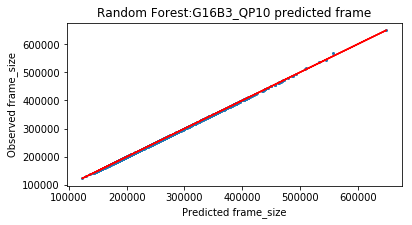

In [78]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(RF.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Random Forest:G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# VAE

In [79]:
#import data
data3 = pd.read_csv("../FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [80]:
data3.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,16,533.33333,I,237784,52.353,52.474,52.951
1,13,433.33333,B,191888,48.114,49.612,50.446
2,14,466.66667,B,198992,48.003,49.608,50.231
3,15,500.00000,B,136112,48.290,50.312,51.118
4,20,666.66667,P,296416,49.951,50.910,51.201


In [81]:
#drop column
data3.drop(('decoded_frame'), axis=1, inplace=True)

In [82]:
data3.dropna(0,inplace= True)

In [83]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data3['video_frame'])
print(list(le.classes_))
data3['video_frame'] = le.transform(data3['video_frame'])

['B', 'I', 'P']


In [84]:
output3 = []
#for l in lag:
for i in range(0, len(data3.frame_size)):
    output3.append(data3['frame_size'].autocorr(i))

In [85]:
len(output3), data3.shape[0]

(11846, 11846)

In [86]:
data3['auto_corr'] = output3
data3.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000
1,433.33333,0,191888,48.114,49.612,50.446,0.037585
2,466.66667,0,198992,48.003,49.608,50.231,0.105441
3,500.00000,0,136112,48.290,50.312,51.118,0.028369
4,666.66667,2,296416,49.951,50.910,51.201,0.780696
5,566.66667,0,151368,48.047,50.108,50.692,0.015772
6,600.00000,0,175072,47.957,50.013,50.635,0.083574
7,633.33333,0,155936,47.958,49.909,50.448,0.003360
8,800.00000,2,289312,49.980,50.992,51.375,0.760796
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946


In [87]:
#zero_data = data[ data['video_frame'] == 0 ]


#data['auto_corr'] = data['frame_size'].autocorr()
data3['auto_corr_next']  = data3['auto_corr'].shift(-1)
data3.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992


In [88]:
data3['comparison_auto_corr'] = np.where(data3["auto_corr"] > data3["auto_corr_next"], 1, 0)
data3.head()

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,1
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,1
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,1


In [89]:
data3 = data3.dropna()

In [90]:
data3['comparison_auto_corr'] = data3['frame_size'] * data3['comparison_auto_corr']
data3.head(10)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,237784
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,198992
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,296416
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574,0
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360,175072
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796,0
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946,289312
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992,0


In [91]:
values3 = data3['comparison_auto_corr'].to_dict()

In [92]:

data3['comparison_auto_corr'] = 0

for idx, row in data3.iterrows():
    data3.at[idx, 'comparison_auto_corr'] = values3.get(idx, row['frame_size'])

In [93]:
data3.head(20)

,arrival_time,video_frame,frame_size,x,y,z,auto_corr,auto_corr_next,comparison_auto_corr
0,533.33333,1,237784,52.353,52.474,52.951,1.000000,0.037585,237784
1,433.33333,0,191888,48.114,49.612,50.446,0.037585,0.105441,0
2,466.66667,0,198992,48.003,49.608,50.231,0.105441,0.028369,198992
3,500.00000,0,136112,48.290,50.312,51.118,0.028369,0.780696,0
4,666.66667,2,296416,49.951,50.910,51.201,0.780696,0.015772,296416
5,566.66667,0,151368,48.047,50.108,50.692,0.015772,0.083574,0
6,600.00000,0,175072,47.957,50.013,50.635,0.083574,0.003360,175072
7,633.33333,0,155936,47.958,49.909,50.448,0.003360,0.760796,0
8,800.00000,2,289312,49.980,50.992,51.375,0.760796,-0.004946,289312
9,700.00000,0,144080,48.094,50.184,50.902,-0.004946,0.065992,0


In [94]:
dataset3 = data3.copy()

In [95]:
dataset3 = dataset3.comparison_auto_corr.values #numpy.ndarray

In [96]:
dataset3 = pd.DataFrame(dataset3)
print(dataset3.shape)

(11844, 1)


In [97]:
dataset3 = dataset3.replace(0, np.nan)
dataset3.dropna(inplace=True)

In [98]:
dataset3.head(10)

,0
0,237784.0
2,198992.0
4,296416.0
6,175072.0
8,289312.0
10,149752.0
12,288384.0
14,158720.0
16,259272.0
18,154600.0


In [99]:
# *****************split into train and test sets********************

train_size = int(len(dataset3) * 0.80)
test_size = len(dataset3) - train_size
data_train = dataset3[0:train_size]
data_test = dataset3[train_size:len(dataset3)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

Data_train (4737, 1) Data_test (1185, 1)
Train_scaled (4737, 1)  Test scaled (1185, 1)


In [100]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 100
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)



train_X (4636, 100) train_y (4636,)
test_X (1084, 100) test_y (1084,)


In [101]:
#X_train, test_X, train_y, test_y 
   # = train_test_split(X, y, test_size=0.2, random_state=1)

train_X, X_val, train_y, y_val = train_test_split(train_X, train_y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [102]:
def fit_batchsize(X,y,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    X = X[0:n_size]
    y = y[0:n_size]
    return X, y

batch_size = 32

train_X, train_y = fit_batchsize(train_X,train_y, batch_size)
X_val, y_val = fit_batchsize(X_val, y_val, batch_size)

test_X,test_y = fit_batchsize(test_X,test_y, batch_size)
print(X_val.shape, train_X.shape)

(1152, 100) (3456, 100)


In [103]:
original_dim = train_X.shape[1]
original_dim

100

In [104]:
batch_size = 32

In [105]:
# Now the trick of the vae, to sample from the 2 dense layers
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

In [106]:
# Define input layer
input_dim = train_X.shape[1]
inputs = Input(shape=(input_dim,))

# Define Encoder layers
latent_space= 2



h_q = Dense(128, activation='relu')(inputs)
mu = Dense(latent_space, activation='linear')(h_q)
log_sigma = Dense(latent_space, activation='linear')(h_q)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian

# instantiate encoder model
encoder = Model(inputs, mu)
encoder.summary()

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_space), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z, name='sampleZ', output_shape=(latent_space,))([mu, log_sigma])


# Define decoder layers in VAE model
decoder_hidden = Dense(128, activation='relu', name='decoder_hidden') 
decoder_out = Dense(input_dim, name = 'decoder_out')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)


# Define a separate Decoder model, that recostruct data from latent variable 
# The decoder model uses eights that was trained with the VAE mode;,
# We need a separate model, if we want to generate data from given data in latent space.
d_in = Input(shape=(latent_space,), name='decoder_input')
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)

decoder = Model(d_in, d_out, name='decoder')
decoder.summary()

# VAE model, Unsupervised leraning for reconstruction of the input data
vae = Model(inputs, outputs, name='vae')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_hidden (Dense)       multiple                  384       
________________________________________

In [107]:
def vae_loss(y_true, y_pred):
    # mse loss
    reconstruction_loss = K.sum(K.square(y_true - y_pred), axis=-1)
    # kl loss
    kl_loss = 1 + log_sigma - K.square(mu) - K.exp(log_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

In [108]:
vae.compile(optimizer='adam', loss=vae_loss)

vae_history = vae.fit(train_X, train_X, batch_size=batch_size, shuffle=False, 
                      validation_data = (X_val, X_val), epochs=500)

Train on 3456 samples, validate on 1152 samples
Epoch 1/500
3456/3456 [==============================] - 0s 87us/sample - loss: 11.8573 - val_loss: 6.3097
Epoch 2/500
3456/3456 [==============================] - 0s 37us/sample - loss: 6.1413 - val_loss: 5.9471
Epoch 3/500
3456/3456 [==============================] - 0s 33us/sample - loss: 5.6987 - val_loss: 5.3735
Epoch 4/500
3456/3456 [==============================] - 0s 34us/sample - loss: 5.1872 - val_loss: 4.9003
Epoch 5/500
3456/3456 [==============================] - 0s 37us/sample - loss: 4.8695 - val_loss: 4.7585
Epoch 6/500
3456/3456 [==============================] - 0s 32us/sample - loss: 4.7100 - val_loss: 4.5867
Epoch 7/500
3456/3456 [==============================] - 0s 37us/sample - loss: 4.6716 - val_loss: 4.6205
Epoch 8/500
3456/3456 [==============================] - 0s 38us/sample - loss: 4.6087 - val_loss: 4.5146
Epoch 9/500
3456/3456 [==============================] - 0s 34us/sample - loss: 4.5858 - val_loss: 4.52

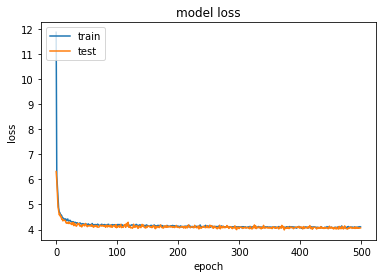

In [109]:
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [110]:
x_train_encoded = encoder.predict(train_X)

pred_train = decoder.predict(x_train_encoded)
mse = np.mean(np.power(train_X - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,
                        'True_class': train_y})

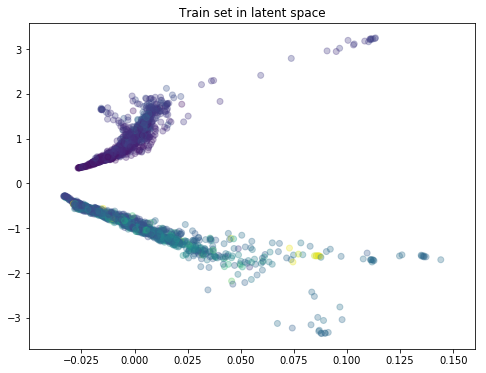

In [111]:
#Latent space
x_train_encoded = encoder.predict(train_X)

plt.figure(figsize=(8, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], 
            c=train_y, alpha=0.3)
plt.title('Train set in latent space')
plt.show()

In [112]:
x_train_encoded = encoder.predict(train_X)

pred_train = decoder.predict(x_train_encoded)

In [113]:
x_test_encoded = encoder.predict(test_X)

In [114]:
# 1. Import the estimator object (model)
from sklearn.ensemble import RandomForestRegressor

# 2. Create an instance of the estimator
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)

# 3. Use the trainning data to train the estimator
X=x_test_encoded
y=test_y
RF.fit(X, y)

RF_pred = RF.predict(X)
# 4. Evaluate the model


models.loc['rmse','VAE_RF'] = np.sqrt(mean_squared_error(y_pred=RF.predict(x_test_encoded), y_true=test_y))
models.loc['rpe','VAE_RF'] = mean_relative_percentage_error(y_pred=RF.predict(x_test_encoded), y_true=test_y)

# Prediction Time !!!!
mse = mean_squared_error(test_y, RF_pred)
print(mse)
rmse = sqrt(mse)
print(rmse)

rpe = mean_relative_percentage_error(test_y, RF_pred)
print ('rpe', rpe)

0.005137462207948673
0.07167609230384056
rpe 36.340023823414505


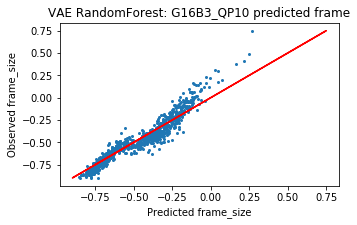

In [115]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(RF.predict(x_test_encoded), test_y, s=4)
ax.plot(test_y, test_y, color='red')
ax.set_title('VAE RandomForest: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

In [116]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor

# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean', n_jobs=-1)

# 3. Use the trainning data to train the estimator
X=x_train_encoded
y= train_y

knn.fit(X, y)



knn_pred= knn.predict(x_test_encoded)

# 4. Evaluate the model
#models.loc['train_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_train), 
 

models.loc['rmse','VAE_KNN'] = np.sqrt(mean_squared_error(y_pred=knn.predict(x_test_encoded), 
                                                   y_true=test_y))
models.loc['rpe','VAE_KNN'] = mean_relative_percentage_error(y_pred=knn.predict(x_test_encoded), 
                                                   y_true=test_y)

# Prediction Time !!!!
mse = mean_squared_error(test_y, knn_pred)
print(mse)
rmse = sqrt(mse)
print(rmse)

rpe = mean_relative_percentage_error(test_y, knn_pred)
print ('rpe', rpe)

0.025926187325463597
0.1610161089005184
rpe 84.54251199988214


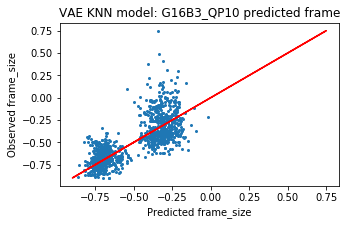

In [117]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(knn.predict(x_test_encoded), test_y, s=4)
ax.plot(test_y, test_y, color='red')
ax.set_title('VAE KNN model: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

In [118]:
models

,Bagging,RF,Boosting,LSTM,CNN,VAE_RF,VAE_KNN
rmse,1027.67,358.161,10236.5,0.120136,0.131352,0.0716761,0.161016
rpe,33.772,33.7915,33.9629,54.5815,29.1666,36.34,84.5425


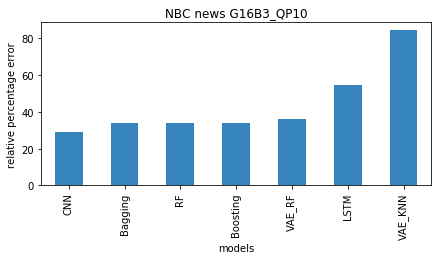

In [119]:
fig, ax = plt.subplots(figsize=(7,3))
bar_width = 0.15

#models.loc['rmse'].sort_values().plot(kind='bar', ax=ax, alpha=0.9)
models.loc['rpe'].sort_values().plot(kind='bar', ax=ax, alpha=0.9)
ax.set_title('NBC news G16B3_QP10');
ax.set_xlabel('models')
ax.set_ylabel('relative percentage error');